In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import time
import re
import nltk
import math
import os
import matplotlib.pyplot as plt
import sklearn.metrics

from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import linear_model
from sklearn.linear_model import Perceptron

from sklearn import svm
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn import linear_model
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import PassiveAggressiveClassifier

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import roc_auc_score
from Bio.SeqUtils.ProtParam import ProteinAnalysis
import sklearn.metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import pickle

%matplotlib inline


## Load csv files

In [2]:
proteins = pd.read_csv('protein-SevenLocations-Feb12.csv')

proteins.head()

,name,sequence,location,label
0,tr|A0A0N4VT99|A0A0N4VT99_HAEPC,LLFVWLPQFIVRPHALLRFWMETDCQGNPPMYGDFEAQRHWMEITI...,0,ER
1,tr|A0A3P8RTP6|A0A3P8RTP6_AMPPE,MGRCVFLILAVLFSVTSSQFIPPYTEDCRTEMYPPKGPTYRGAVGW...,3,lysosome
2,sp|O89290|POL_HV193,MGARASVLSGGKLDAWEKIRLRPGGKKKYRLKHLVWASRELERFAL...,6,plasma_membrane
3,tr|S2JAV3|S2JAV3_MUCC1,MVKKQKKKQPITARVQPTEAKFKHSRVETARLIRKFHVLNKELAKC...,5,nucleus
4,sp|A5I7A5|UVRC_CLOBH,MFDLEYQLKNLPDKPGVYLMKNNLGEIIYVGKAKILKNRVRQYFQK...,2,cytoplasm


In [3]:
proteins.shape

(700483, 4)

In [4]:
# permute/scramble/shuffle rows of the dataframe
proteins = proteins.sample(frac=1)

In [5]:
proteins.location.value_counts()

5    178929
0    118331
4    109750
2     97116
1     75188
3     60911
6     60258
Name: location, dtype: int64

In [6]:
proteins.label.value_counts()

nucleus            178929
ER                 118331
mitochondria       109750
cytoplasm           97116
Golgi               75188
lysosome            60911
plasma_membrane     60258
Name: label, dtype: int64

In [7]:
# remove the duplicate protein sequences
proteins = proteins.drop_duplicates(subset='sequence', keep="first")

# remove nan from 'sequence' column
proteins = proteins[proteins['sequence'].notnull()]

proteins.shape

(700483, 4)

In [8]:
proteins.label.value_counts()

nucleus            178929
ER                 118331
mitochondria       109750
cytoplasm           97116
Golgi               75188
lysosome            60911
plasma_membrane     60258
Name: label, dtype: int64

## Transform the protein sequence data with CountVectorizer to get peptide frequency. Split the data into training & test sets.

In [9]:
# Peptide count is used for analysis
peptide_size = 6
vect = CountVectorizer(min_df=1,token_pattern=r'\w{1}',ngram_range=(peptide_size,peptide_size))

In [10]:
X = vect.fit_transform(proteins.sequence)
y = proteins.location

In [11]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state =42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

((560386, 34701392), (560386,))
((140097, 34701392), (140097,))


In [12]:
y_test.value_counts()

5    35844
0    23753
4    21711
2    19458
1    15054
3    12148
6    12129
Name: location, dtype: int64

## Classifiers

In [13]:
%%time
mnb = MultinomialNB()
mnb.fit(X_train, y_train)
# evaluate accuracy of our model on test data
print("MNB classifier Score: {:.2f}".format(mnb.score(X_test, y_test)))
print()

MNB classifier Score: 0.92
()
CPU times: user 36.2 s, sys: 20.6 s, total: 56.8 s
Wall time: 1min 5s


In [14]:
%%time
pac = PassiveAggressiveClassifier()
pac.fit(X_train, y_train)
# evaluate accuracy of our model on test data
print("Passive Aggressive classifier Score: {:.2f}".format(pac.score(X_test, y_test)))
print()

/Users/scottlew/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in PassiveAggressiveClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


Passive Aggressive classifier Score: 0.94
()
CPU times: user 3min 39s, sys: 16.2 s, total: 3min 55s
Wall time: 10min 17s


In [15]:
vote_prediction_pac = pac.predict(X_test)
print(classification_report(vote_prediction_pac, y_test))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96     23334
           1       0.96      0.97      0.97     14790
           2       0.91      0.91      0.91     19511
           3       0.96      0.98      0.97     11845
           4       0.93      0.97      0.95     20885
           5       0.96      0.92      0.94     37569
           6       0.88      0.88      0.88     12163

   micro avg       0.94      0.94      0.94    140097
   macro avg       0.94      0.94      0.94    140097
weighted avg       0.94      0.94      0.94    140097



In [16]:
%%time
pac2 = PassiveAggressiveClassifier(loss='squared_hinge')
pac2.fit(X_train, y_train)
# evaluate accuracy of our model on test data
print("Passive Aggressive classifier with squared hinge loss Score: {:.2f}".format(pac2.score(X_test, y_test)))
print()

Passive Aggressive classifier with squared hinge loss Score: 0.94
()
CPU times: user 3min 2s, sys: 10.8 s, total: 3min 13s
Wall time: 3min 19s


In [17]:
# Generate Confusion Matrix 
actual = y_test
predictions = pac2.predict(X_test)
print('Confusion Matrix for Majority Vote Model')
print()
cm = confusion_matrix(actual,predictions)
print(cm)

Confusion Matrix for Majority Vote Model
()
[[22602   325    75     9    82   188   472]
 [  365 14367    34    26    25    74   163]
 [   31     9 17657    40   181  1022   518]
 [   39     8    63 11646    21   127   244]
 [  115    11   359    13 20219   442   552]
 [   59     4   741    29   197 34123   691]
 [   55    11   426    80   112   531 10914]]


In [18]:
%%time
sgd = linear_model.SGDClassifier(max_iter=1000, tol=1e-3)
sgd.fit(X_train, y_train)
# evaluate accuracy of our model on test data
print("SGD classifier Score: {:.2f}".format(sgd.score(X_test, y_test)))
print()

SGD classifier Score: 0.94
()
CPU times: user 7min 43s, sys: 12 s, total: 7min 55s
Wall time: 11min 43s


In [19]:
%%time
per = Perceptron(tol=1e-3, random_state=0).fit(X_train,y_train)
# evaluate accuracy of our model on test data
print("Perceptron classifier Score: {:.2f}".format(per.score(X_test, y_test)))
print()

Perceptron classifier Score: 0.93
()
CPU times: user 18min, sys: 14.9 s, total: 18min 15s
Wall time: 26min 15s


## Majority Vote Classifiers

In [20]:
# three classifiers: SGD, PassiveAggressiveClassifier, MNB

clf1 = linear_model.SGDClassifier(max_iter=1000, tol=1e-3)
clf2 = PassiveAggressiveClassifier()
clf3 = MultinomialNB()

In [21]:
eclf1 = VotingClassifier(estimators=[('sgd', clf1), ('pac', clf2), ('mnb', clf3)], voting='hard')
eclf1 = eclf1.fit(X_train, y_train)
# evaluate accuracy of our model on test data
print("Majority Voting Classifier Score: {:.2f}".format(eclf1.score(X_test, y_test)))

Majority Voting Classifier Score: 0.94


In [22]:
# Generate Confusion Matrix 
actual = y_test
predictions = eclf1.predict(X_test)
print('Confusion Matrix for Majority Vote Model')
print()
cm = confusion_matrix(actual,predictions)
print(cm)

Confusion Matrix for Majority Vote Model
()
[[22703   356    78    12    83   240   281]
 [  346 14474    38    20    20   100    56]
 [   31     9 17763    44   154  1152   305]
 [   36    20    92 11670    11   167   152]
 [  112    19   442    15 20214   616   293]
 [   63     6   757    32   175 34457   354]
 [   60    16   463    79   104   640 10767]]


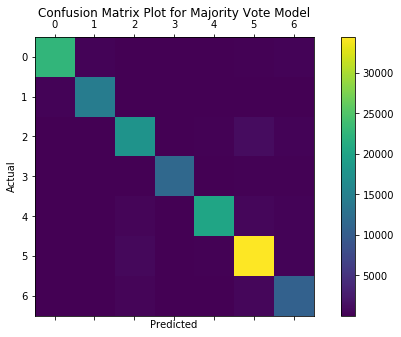

In [23]:
# Nice plot of confusion matrix
# Adjust size of confusion matrix by following code taken from StackOverflow
# https://stackoverflow.com/questions/43021762/matplotlib-how-to-change-figsize-for-matshow
plt.figure(figsize=(10,5))
plt.matshow(cm, fignum=1)

plt.title('Confusion Matrix Plot for Majority Vote Model')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.show()

In [24]:
vote_prediction1 = eclf1.predict(X_test)
print(classification_report(vote_prediction1, y_test))

              precision    recall  f1-score   support

           0       0.96      0.97      0.96     23351
           1       0.96      0.97      0.97     14900
           2       0.91      0.90      0.91     19633
           3       0.96      0.98      0.97     11872
           4       0.93      0.97      0.95     20761
           5       0.96      0.92      0.94     37372
           6       0.89      0.88      0.88     12208

   micro avg       0.94      0.94      0.94    140097
   macro avg       0.94      0.94      0.94    140097
weighted avg       0.94      0.94      0.94    140097



In [25]:
%%time
clf1a = linear_model.SGDClassifier(max_iter=1000, tol=1e-3)
clf2a = PassiveAggressiveClassifier(C=0.1)
clf3a = MultinomialNB(alpha=50)

eclf2 = VotingClassifier(estimators=[('sgd', clf1a), ('pac', clf2a), ('mnb', clf3a)], voting='hard')
eclf2.fit(X_train, y_train)
# evaluate accuracy of our model on test data
print("Majority Voting Classifier Score: {:.2f}".format(eclf2.score(X_test, y_test)))
print()

Majority Voting Classifier Score: 0.94
()
CPU times: user 12min 19s, sys: 1min 11s, total: 13min 31s
Wall time: 15min 7s


In [26]:
vote_prediction2 = eclf2.predict(X_test)
print(classification_report(vote_prediction2, y_test))

              precision    recall  f1-score   support

           0       0.96      0.97      0.96     23561
           1       0.96      0.97      0.97     14865
           2       0.91      0.91      0.91     19403
           3       0.96      0.98      0.97     11850
           4       0.93      0.97      0.95     20755
           5       0.97      0.91      0.94     37882
           6       0.87      0.90      0.89     11781

   micro avg       0.94      0.94      0.94    140097
   macro avg       0.94      0.95      0.94    140097
weighted avg       0.94      0.94      0.94    140097



In [27]:
%%time
clf1d = linear_model.SGDClassifier(max_iter=1000, tol=1e-3)
clf2d = PassiveAggressiveClassifier(C=0.1)
clf3d = Perceptron(tol=1e-3, random_state=0)
clf4d = MultinomialNB(alpha=50)

eclf3 = VotingClassifier(estimators=[('sgd', clf1d), ('pac', clf2d), ('per', clf3d),('mnb',clf4d)], voting='hard')
eclf3.fit(X_train, y_train)
# evaluate accuracy of our model on test data
print("Majority Voting Classifier Score: {:.2f}".format(eclf3.score(X_test, y_test)))
print()

Majority Voting Classifier Score: 0.94
()
CPU times: user 28min 20s, sys: 1min 27s, total: 29min 47s
Wall time: 31min 26s


In [28]:
vote_prediction3 = eclf3.predict(X_test)
print(classification_report(vote_prediction3, y_test))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96     23781
           1       0.96      0.97      0.97     14823
           2       0.91      0.91      0.91     19455
           3       0.96      0.98      0.97     11903
           4       0.93      0.97      0.95     20847
           5       0.96      0.92      0.94     37758
           6       0.86      0.91      0.88     11530

   micro avg       0.94      0.94      0.94    140097
   macro avg       0.94      0.95      0.94    140097
weighted avg       0.94      0.94      0.94    140097



## Cross Validation

In [29]:
from sklearn.model_selection import cross_val_score, cross_val_predict

In [30]:
pac_cv = PassiveAggressiveClassifier()
scores = cross_val_score(pac_cv,X,y, cv = 5)
print("Cross-validation scores for Passive Aggressive Classifier: {}".format(scores))
print()
print("The average accuracy score for Passive Aggressive Classifier is: ")
print(np.mean(scores))

Cross-validation scores for Passive Aggressive Classifier: [0.94154889 0.94136206 0.94021999 0.94118277 0.94202464]
()
The average accuracy score for Passive Aggressive Classifier is: 
0.9412676699612105


In [31]:
clf1a = linear_model.SGDClassifier(max_iter=1000, tol=1e-3)
clf2a = PassiveAggressiveClassifier(C=0.1)
clf3a = MultinomialNB(alpha=50)

voteClass_cv = VotingClassifier(estimators=[('sgd', clf1a), ('pac', clf2a), ('mnb', clf3a)], voting='hard')

scores = cross_val_score(voteClass_cv,X,y, cv = 5)
print("Cross-validation scores for Voting Classifier: {}".format(scores))
print()
print("The average accuracy score for Voting Classifier is: ")
print(np.mean(scores))

Cross-validation scores for Voting Classifier: [0.94173448 0.94166899 0.94094806 0.9415825  0.94225306]
()
The average accuracy score for Voting Classifier is: 
0.941637415106312
